In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
import datetime
import numpy as np
import matplotlib.dates as mdates
import data_processing as dp

In [23]:
"""
plot
Plots data with 7 day average

data: dataframe time series with column 'date' and data in 1st column
plot_color: Color to use for plot
label: string of plot label
rolling: Boolean, True to overlay 7-day average
"""
def plot(data, ax=None, plot_color="blue", label="", rolling=True, font={'family': 'serif', 'size':13, 'weight':'light'}):
    ax = ax or plt.gca()
    x, y0 = data.date, data.iloc[:,1]
    if(rolling):
        y1 = data.iloc[:,1].rolling(7).mean()
        ax.plot(x, y0, alpha=.3, color=plot_color)
        ax.plot(x, y1, color=plot_color)
        ax.fill_between(x, y1, 0, facecolor=plot_color, color=plot_color, alpha=0.2)
    else:
        ax.plot(x, y0, color=plot_color)
        ax.fill_between(x, y0, 0, facecolor=plot_color, color=plot_color, alpha=0.2)
    ax.set_title(label, fontdict=font)
    subtext = []
    for i in [-1,-2,-7]:
        last_update_day = x.iloc[i].strftime('%b-%d')
        last_val = round(y0.iloc[i], 1)
        last_val_formatted = '{:,}'.format(last_val)
        subtext.append(f" {last_update_day}: {last_val_formatted}")

    ax.text(.5, 0.97, subtext[0], ha='center', transform=ax.transAxes, fontdict=font)
    ax.text(.5, 0.94, subtext[1], ha='center',transform=ax.transAxes, fontdict=font)
    ax.text(.5, 0.91, subtext[2], ha='center',transform=ax.transAxes, fontdict=font)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
    ax.grid(alpha=.4)
    ax.set_ylim(0)
    return ax




In [24]:
def plot_four(region="USA", start_date=pd.Timestamp(2020,1,1), end_date=pd.Timestamp.today()):
    if region == "USA":
        pos = dp.get_us_positivity(start_date, end_date)
        case = dp.get_us_cases(start_date, end_date)
        death = dp.get_us_deaths(start_date, end_date)
        hosp = dp.get_us_hospitalizations(start_date, end_date)
    else:
        pos = dp.get_state_positivity(region, start_date, end_date)
        case = dp.get_state_cases(region, start_date, end_date)
        death = dp.get_state_deaths(region, start_date, end_date)
        hosp = dp.get_state_hospitalizations(region, start_date, end_date)


    fig, axs = plt.subplots(1,4, figsize=(25,10))
    plot(pos, axs[0], plot_color="purple", label=f"Test Positivity in {region}")
    plot(case, axs[1], plot_color="red", label=f"Cases in {region}")
    plot(hosp, axs[2], plot_color="blue", label=f"Hospitalizations in {region}")
    plot(death, axs[3], plot_color="black", label=f"Deaths in {region}")
    fig.autofmt_xdate()
    plt.show()

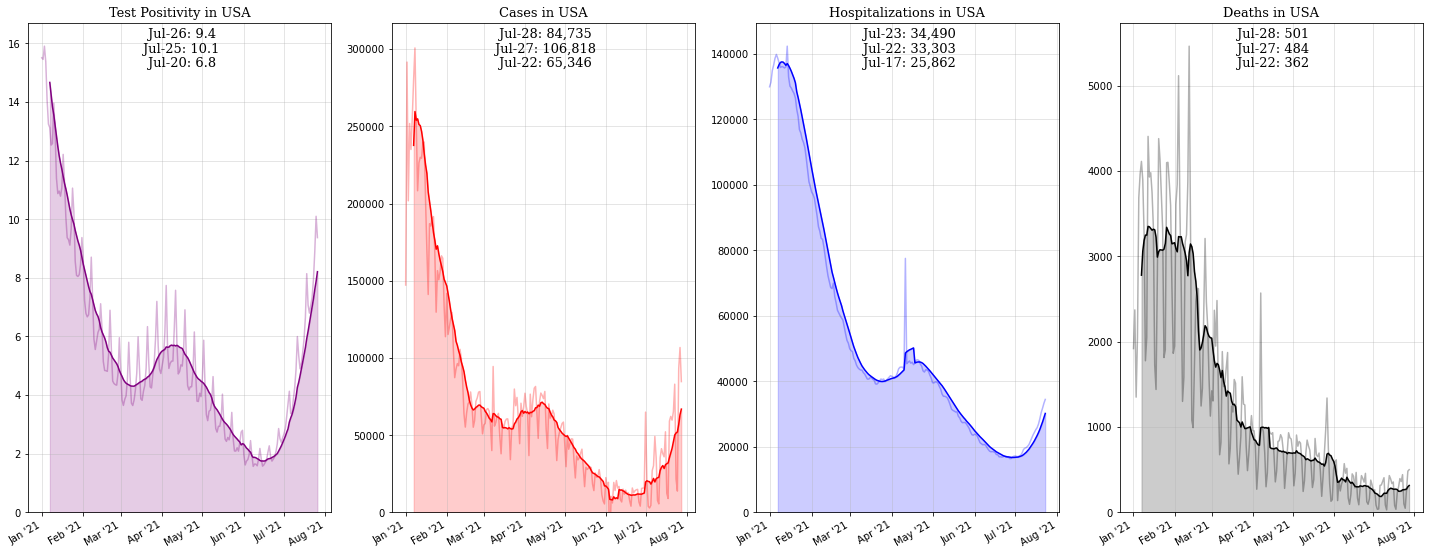

In [25]:
plot_four(start_date=pd.Timestamp(2021,1,1), end_date=pd.Timestamp.today())